In [1]:
import os
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
from image_processing.aran import (
    get_aran, 
    resize_to_aspect_ratio
)
from image_processing.preprocessing import (
    get_boundary,
    remove_padding,
    get_centroid,
    pad_to_square
)

In [3]:
# show a list of images
def show(imgs, col=5, titles=None, gray=True, chinese_title=False):
    
    chinese_font = mpl.font_manager.FontProperties(fname='../fonts/heiti.ttf')

    row = max((len(imgs) + col - 1) // col, 2)
    plt.figure(figsize=(col * 2.5, row * 2))
    
    for i in range(len(imgs)):
        ax = plt.subplot(row, col, i + 1)
        if gray:
            plt.imshow(imgs[i], 'gray')
        else:
            plt.imshow(imgs[i])
        if titles is not None:
            if chinese_title:
                plt.title(titles[i], fontproperties=chinese_font, fontsize=16)
            else:
                plt.title(titles[i])
        plt.axis("off")

In [4]:
"""
Image resampling by bilinear interpolation
If x_mapped and y_mapped are 1D arrays, they will be repeated to form 2D arrays
@param x_mapped : array of shape (m, n), specifies the x-coord of the desired pixel value in the original image
@param y_mapped : array of shape (m, n), specifies the y-coord of the desired pixel value in the original image
@param img      :
@return         : image of shape (m, n)
"""
def interpolate_bilinear(x_mapped, y_mapped, img):
    
    # form 2D arrays
    if len(np.array(x_mapped).shape) == 1 and len(np.array(y_mapped).shape) == 1:
        x_mapped, y_mapped = np.meshgrid(x_mapped, y_mapped)
    
    # add background pixels to deal with edge cases
    h, w = img.shape
    img = np.concatenate([img, np.zeros((h, 1))], axis=1)
    img = np.concatenate([img, np.zeros((1, w + 1))], axis=0)
    
    # get neighbouring coordinates
    x_mapped_floor = np.floor(x_mapped).astype(int).clip(min=0, max=w - 1)
    y_mapped_floor = np.floor(y_mapped).astype(int).clip(min=0, max=h - 1)
    x_mapped_ceil = np.ceil(x_mapped).astype(int).clip(min=0, max=w - 1)
    y_mapped_ceil = np.ceil(y_mapped).astype(int).clip(min=0, max=h - 1)
    
    # get weights of each portion
    w_top_left = (1 - (x_mapped % 1)) * (1 - (y_mapped % 1))
    w_top_right = (x_mapped % 1) * (1 - (y_mapped % 1))
    w_btm_left = (1 - (x_mapped % 1)) * (y_mapped % 1)
    w_btm_right = (x_mapped % 1) * (y_mapped % 1)

    # interpolate (sum([area * weight for each portion]))
    interpolated = img[y_mapped_floor, x_mapped_floor] * w_top_left + \
        img[y_mapped_ceil, x_mapped_floor] * w_btm_left + \
        img[y_mapped_floor, x_mapped_ceil] * w_top_right + \
        img[y_mapped_ceil, x_mapped_ceil] * w_btm_right
    
    interpolated[x_mapped < 0] = 0
    interpolated[y_mapped < 0] = 0
    interpolated[x_mapped >= w] = 0
    interpolated[y_mapped >= h] = 0

    return interpolated


def get_second_moment(img, one_sided=False):
    
    h, w = img.shape
    x_c, y_c = get_centroid(img)
    
    tmp_m02 = np.multiply(
        np.square((np.array(range(h)) - y_c)), 
        img.sum(axis=1)
    )

    tmp_m20 = np.multiply(
        np.square((np.array(range(w)) - x_c)), 
        img.sum(axis=0)
    )
    
    if not one_sided:
        m02 = tmp_m02.sum() / max(img.sum(), 1e-10)
        m20 = tmp_m20.sum() / max(img.sum(), 1e-10)
        return m02, m20
    else:
        idx = range(y_c)
        m02_minus = tmp_m02[idx].sum() / max(img[idx, :].sum(), 1e-10)
        idx = range(y_c + 1, len(tmp_m02))
        m02_plus = tmp_m02[idx].sum() / max(img[idx, :].sum(), 1e-10)
        idx = range(x_c)
        m20_minus = tmp_m20[idx].sum() / max(img[:, idx].sum(), 1e-10)
        idx = range(x_c + 1, len(tmp_m20))
        m20_plus = tmp_m20[idx].sum() / max(img[:, idx].sum(), 1e-10)

        return m02_minus, m02_plus, m20_minus, m20_plus

In [10]:
def get_bounded_image(img, bound_x, bound_y):
    
    h, w = img.shape
    
    # shift image, together with its boundary, then crop image

    bound_x_shifted, bound_y_shifted = bound_x, bound_y
    if bound_x[0] < 0:
        bound_x_shifted = (0, bound_x[1] - bound_x[0])
    if bound_y[0] < 0:
        bound_y_shifted = (0, bound_y[1] - bound_y[0])

    pad_width = [
        [max(-bound_y[0], 0), max(bound_y[1] + 1 - h, 0)], 
        [max(-bound_x[0], 0), max(bound_x[1] + 1 - w, 0)]
    ]

    img = np.pad(img, pad_width, mode='constant', constant_values=0)

    img = img[
        bound_y_shifted[0]:bound_y_shifted[1] + 1, 
        bound_x_shifted[0]:bound_x_shifted[1] + 1
    ]
    
    return img

In [11]:
# BMN
        
    
# find new boundary for BMN
def get_bmn_scaling(img, beta=2):
    
    x_c_init, y_c_init = get_centroid(img)

    moments = get_second_moment(img, one_sided=True)
    m02_minus, m02_plus, m20_minus, m20_plus = moments

    delta_y_minus = m02_minus ** 0.5 * beta
    delta_y_plus = m02_plus ** 0.5 * beta
    delta_x_minus = m20_minus ** 0.5 * beta
    delta_x_plus = m20_plus ** 0.5 * beta


    bound_x = (int(x_c_init - delta_x_minus), int(x_c_init + delta_x_plus))
    bound_y = (int(y_c_init - delta_y_minus), int(y_c_init + delta_y_plus))

    return bound_x, bound_y


def get_bmn_mapping(img, beta=2):

    bound_x, bound_y = get_bmn_scaling(img, beta=beta)
    
    x_c_init, y_c_init = get_centroid(img)
    h, w = img.shape

    original_x = [bound_x[0], x_c_init, bound_x[1]]
    original_x = [x - bound_x[0] for x in original_x]
    normalized_x = [0, w//2, w]
    a1, b1, c1 = np.polyfit(normalized_x, original_x, 2)

    original_y = [bound_y[0], y_c_init, bound_y[1]]
    original_y = [y - bound_y[0] for y in original_y]
    normalized_y = [0, h//2, h]
    a2, b2, c2 = np.polyfit(normalized_y, original_y, 2)

    x = np.array(range(0, w))
    x_mapped = a1 * x ** 2 + b1 * x + c1

    y = np.array(range(0, h))
    y_mapped = a2 * y ** 2 + b2 * y + c2

    # replace critical curves with clipping
    x_mapped = np.clip(x_mapped, a_min=0, a_max=bound_x[1] - bound_x[0])
    y_mapped = np.clip(y_mapped, a_min=0, a_max=bound_y[1] - bound_y[0])
    
    return x_mapped, y_mapped, bound_x, bound_y



def bimoment_normalization(img, beta=2):

    x_c_init, y_c_init = get_centroid(img)
    x_mapped, y_mapped, bound_x, bound_y = get_bmn_mapping(img, beta=beta)
    img = get_bounded_image(img, bound_x, bound_y)
    img = interpolate_bilinear(x_mapped, y_mapped, img)
    img = (img > img.max() / 2 - (img.max()/ 100)).astype('uint8')
    
    # resize based on aran
    img = resize_to_aspect_ratio(img, get_aran(img))
    
    return img

In [12]:
# MN

# find scaling and new boundary for MN
def get_mn_scaling(img, alpha=4):
    
    x_c_init, y_c_init = get_centroid(img)
    
    m02, m20 = get_second_moment(img, one_sided=False)
    delta_y = alpha * m02 ** 0.5
    delta_x = alpha * m20 ** 0.5

    delta_y_half = int(delta_y // 2)
    delta_x_half = int(delta_x // 2)
    bound_x = (x_c_init - delta_x_half, x_c_init + delta_x_half)
    bound_y = (y_c_init - delta_y_half, y_c_init + delta_y_half)
    
    return delta_x, delta_y, bound_x, bound_y


def get_mn_mapping(img, alpha=4):
    
    x_c_init, y_c_init = get_centroid(img)
    
    h, w = img.shape
    y_c = h // 2
    x_c = w // 2
    
    delta_x, delta_y, bound_x, bound_y = get_mn_scaling(img, alpha=alpha)

    # coordinate mapping
    x = np.array(range(bound_x[0], bound_x[1]))
    y = np.array(range(bound_y[0], bound_y[1]))
    x_mapped = (x - x_c_init) * w / delta_x + x_c
    x_mapped = np.clip(x_mapped, a_min=0, a_max=w)
    y_mapped = (y - y_c_init) * h / delta_y + y_c
    y_mapped = np.clip(y_mapped, a_min=0, a_max=h)
    
    return x_mapped, y_mapped, bound_x, bound_y


def inverse_coord_mapping(x_mapped, y_mapped, shape_cropped, shape_init):
    
    h_init, w_init = shape_init
    h_cropped, w_cropped = shape_cropped
    
    scaled_idx = np.linspace(0, h_cropped - 1, h_init)
    y_mapped_inv = interpolate_bilinear(
        y_mapped, [0],
        np.expand_dims(scaled_idx, axis=0)
    )[0, :]

    scaled_idx = np.linspace(0, w_cropped - 1, w_init)
    x_mapped_inv = interpolate_bilinear(
        x_mapped, [0],
        np.expand_dims(scaled_idx, axis=0)
    )[0, :]
    
    return x_mapped_inv, y_mapped_inv


def moment_normalization(img, alpha=4):
    
    shape_init = img.shape
    
    x_mapped, y_mapped, bound_x, bound_y = get_mn_mapping(img, alpha=alpha)
    img = get_bounded_image(img, bound_x, bound_y)
    
    shape_cropped = img.shape
    
    x_mapped_inv, y_mapped_inv = inverse_coord_mapping(x_mapped, y_mapped, shape_cropped, shape_init)
    
    img = interpolate_bilinear(x_mapped_inv, y_mapped_inv, img)
    img = (img > img.max() / 2 - (img.max()/ 100)).astype('uint8')
    img = resize_to_aspect_ratio(img, get_aran(img))
    
    return img


In [13]:
# P2DBMN utils

def get_weighted_fs(img, axis, w0=0.75):
    
    shape = img.shape
    y_c = shape[axis] // 2
    
    
    idx = np.array(range(shape[axis]))
    
    w1 = np.array(range(shape[axis]), dtype='float64')
    w1[idx < y_c] = (y_c - w1[idx < y_c]) / y_c * w0
    w1[idx >= y_c] = 0
    w1 = np.clip(w1, a_min=0, a_max=1)

    w2 = np.array(range(shape[axis]), dtype='float64')
    w2[idx < y_c] = 1 - (y_c - w2[idx < y_c]) / y_c * w0
    w2[idx >= y_c] = 1 - (w2[idx >= y_c] - y_c) / (shape[axis] - y_c) * w0
    w2 = np.clip(w2, a_min=0, a_max=1)

    w3 = np.array(range(shape[axis]), dtype='float64')
    w3[idx < y_c] = 0
    w3[idx >= y_c] = (w3[idx >= y_c] - y_c) / (shape[axis] - y_c) * w0
    w3 = np.clip(w3, a_min=0, a_max=1)

    fs, wms = [], []
    for weights in [w1, w2, w3]:
        wms.append(weights)
        wm = np.expand_dims(weights, axis=1 - axis) \
            .repeat(shape[1 - axis], axis=1 - axis)
        f = np.multiply(img.astype('float64'), wm)
        fs.append(f)
    
    return fs, wms


# horizontal = True if horizontal strip is passed in
def get_p2dbmn_part_mapping(f_i, horizontal, beta):

    x_c_init, y_c_init = get_centroid(f_i)
    axis = 1 if horizontal else 0
    n = f_i.shape[axis]

    moments = get_second_moment(f_i, one_sided=True)
    m02_minus, m02_plus, m20_minus, m20_plus = moments

    if horizontal:
        delta_x_minus = m20_minus ** 0.5 * beta
        delta_x_plus = m20_plus ** 0.5 * beta
        bound = ((x_c_init - delta_x_minus), (x_c_init + delta_x_plus))
        original = [bound[0], x_c_init, bound[1]]

    else:
        delta_y_minus = m02_minus ** 0.5 * beta
        delta_y_plus = m02_plus ** 0.5 * beta    
        bound = ((y_c_init - delta_y_minus), (y_c_init + delta_y_plus))
        original = [bound[0], y_c_init, bound[1]]
    
    bound = (int(bound[0]), int(bound[1]))
    normalized = [0, n // 2, n]

    a, b, c = np.polyfit(normalized, original, 2)

    coords = np.array(range(n))
    coords_mapped = a * coords ** 2 + b * coords + c
    
    return coords_mapped



def get_p2dbmn_mapping(img, beta, w0):
    
    h, w = img.shape

    # get weights and weighted image
    fs_horizontal, wms_horizontal = get_weighted_fs(img, axis=0)
    fs_vertical, wms_vertical = get_weighted_fs(img, axis=1)

    # get mapping of each strip
    mappings_x = [get_p2dbmn_part_mapping(f_i, horizontal=True, beta=beta) for f_i in fs_horizontal]
    mappings_y = [get_p2dbmn_part_mapping(f_i, horizontal=False, beta=beta) for f_i in fs_vertical]

    # combine the three mappings
    wms_h_exp = [np.expand_dims(wm, axis=1).repeat(w, axis=1) for wm in wms_horizontal]
    mappings_x_exp = [np.expand_dims(mapping, axis=0).repeat(h, axis=0) for mapping in mappings_x]
    x_mapped = \
        wms_h_exp[0] * mappings_x_exp[0] + \
        wms_h_exp[1] * mappings_x_exp[1] + \
        wms_h_exp[2] * mappings_x_exp[2]

    wms_v_exp = [np.expand_dims(wm, axis=0).repeat(h, axis=0) for wm in wms_vertical]
    mappings_y_exp = [np.expand_dims(mapping, axis=1).repeat(w, axis=1) for mapping in mappings_y]
    y_mapped = \
        wms_v_exp[0] * mappings_y_exp[0] + \
        wms_v_exp[1] * mappings_y_exp[1] + \
        wms_v_exp[2] * mappings_y_exp[2]
    
    return x_mapped, y_mapped


    
    
def p2d_bimoment_normalization(img, beta=2, w0=0.5):
    
    x_mapped, y_mapped = get_p2dbmn_mapping(img, beta=beta, w0=w0)
    
    img  = interpolate_bilinear(x_mapped, y_mapped, img)
    img = (img > img.max() / 2 - (img.max()/ 100)).astype('uint8')
    img = resize_to_aspect_ratio(img, get_aran(img))
        
    return img

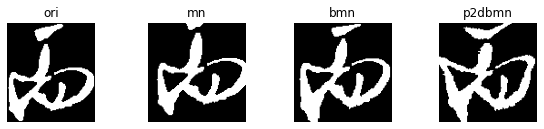

In [14]:
fname = '../data/shufadict/clean/而/5d2a6b1620b703e2f112c61d527585b9.png'
# fname = '/Users/kx/desktop/test4.png'
img_init = cv2.imread(fname)[:, :, 0]
img_init = remove_padding(img_init)

img_mn = moment_normalization(img_init, alpha=4)
img_bmn = bimoment_normalization(img_init, beta=2)
img_p2dbmn = p2d_bimoment_normalization(img_init, beta=2, w0=0.5)

show(
    [img_init, img_mn, img_bmn, img_p2dbmn], 
    col=4, 
    titles=['ori', 'mn', 'bmn', 'p2dbmn']
)

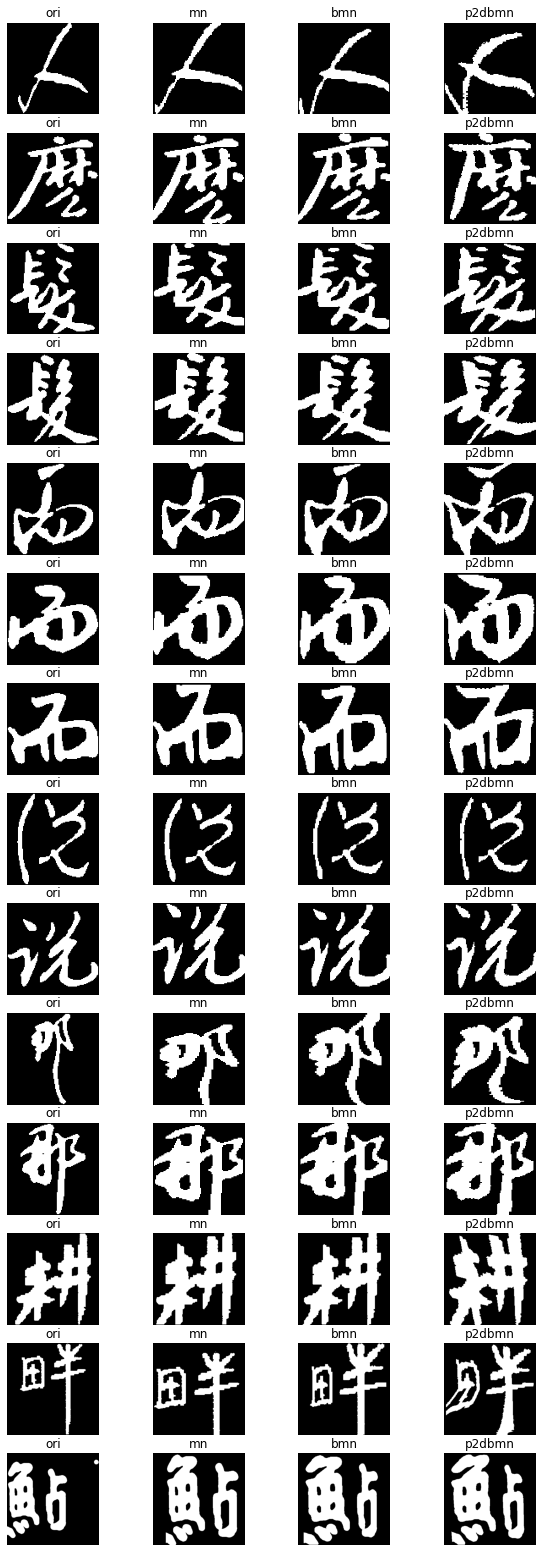

In [15]:
imgs = []
titles = []
fnames = [
    '../data/shufadict/clean/人/e56dbd8247f81ef7dc1a31e27d307b82.png',
    '../data/shufadict/clean/么/0f34c618b9643d08a1469892702d2007.png',
    '../data/shufadict/clean/发/2fc5822be330238690204267753d14c2.png',
    '../data/shufadict/clean/发/25c7c8b5d972ffd69870296df43a6884.png',
    '../data/shufadict/clean/而/5d2a6b1620b703e2f112c61d527585b9.png',
    '../data/shufadict/clean/而/9b00ab5a91f79fca33e8a8c1c0872643.png',
    '../data/shufadict/clean/而/f1e2bd97b285035a03de31e17fb0fd1a.png',
    '../data/shufadict/clean/说/2bed014d30fb1c554f84abeb24d64e6f.png',
    '../data/shufadict/clean/说/4aa84d1b2c3528603b4c7e63dd9e0b8b.png',
    '../data/shufadict/clean/那/8f5a4f9759115f2dc758d2253019c559.png',
    '../data/shufadict/clean/那/af052eb17df40cf2de16c4c748991964.png',
    '/Users/kx/desktop/test.png',
    '/Users/kx/desktop/test2.png',
    '/Users/kx/desktop/test3.png'
]
for fname in fnames:
    
    img_init = cv2.imread(fname)[:, :, 0]
    img_init = (img_init > 0) * 255
    img_init = remove_padding(img_init)
    
    img_mn = moment_normalization(img_init, alpha=4)
    img_bmn = bimoment_normalization(img_init, beta=2)
    img_p2dbmn = p2d_bimoment_normalization(img_init, beta=2, w0=0.5)
    
    imgs += [img_init, img_mn, img_bmn, img_p2dbmn]
    titles += ['ori', 'mn', 'bmn', 'p2dbmn']

imgs = [pad_to_square((img > 0).astype('uint8'), max(img.shape)) for img in imgs]
show(imgs, col=4, titles=titles)

---

# PDF estimation

In [ ]:
import scipy.stats as stats
import random
from tqdm.notebook import tqdm
# from multiprocessing import Pool
from multiprocess import Pool

In [ ]:
DATA_PATH = '../data/shufadict/clean'
N = 16

In [ ]:
chars = [x for x in os.listdir(DATA_PATH) if x[0] != '.']
char_to_id = dict(zip(chars, range(len(chars))))

In [ ]:
def preprocess_image_pdfe(img, N, norm_func):
    
    img = remove_padding(img)
    img_norm = norm_func(img, get_bmn_mapping, alpha=4)
    
    h, w = img_norm.shape
    if h > w:
        img_norm = cv2.resize(img_norm, (N, int(w / h * N)))
    else:
        img_norm = cv2.resize(img_norm, (int(h / w * N), N))
    img_norm = (img_norm > 0).astype('uint8')
    img_norm = pad_to_square(img_norm, N)
    
    return img_norm


def get_kernel_contour(kernel, N, step):
    # get meshgrid and its coordinates
    xx, yy = np.mgrid[0:N:step, 0:N:step]
    positions = np.vstack([xx.ravel(), yy.ravel()])

    # estimation
    f = np.reshape(kernel(positions).T, xx.shape)
    f = np.rot90(np.rot90(np.rot90(f)))
    
    return f

def plot_kernel_contour(kernel, N, step):
    
    f = get_kernel_contour(kernel, N, step)

    # plot
    fig = plt.figure(figsize=(3,3))
    ax = fig.gca()
    ax.set_xlim(0, N)
    ax.set_ylim(0, N)
    # ax.contourf(xx, yy, f, cmap='coolwarm')
    # ax.contour(xx, yy, f, colors='black')
    ax.imshow(np.rot90(f), cmap='coolwarm', extent=[0, N, 0, N])
    ax.axis("off")
    

## Preprocess data

In [ ]:
train = {}
val = {}
test = {}

for char in tqdm(chars):
    path = os.path.join(DATA_PATH, char)
    fnames = [os.path.join(path, f) for f in os.listdir(path) if f[0] != '.']
    imgs = []

    for fname in fnames:
        img = cv2.imread(fname)[:, :, 0]
        img_norm = preprocess_image_pdfe(img, N, moment_normalization_skel)
        imgs.append(img_norm)

    random.shuffle(imgs)
    test[char] = imgs[0:20]
    val[char] = imgs[20:40]
    train[char] = imgs[40:]

## PDF Estimation

In [ ]:
Xs = [None] * len(chars)
kernels = [None] * len(chars)
for i in tqdm(range(len(chars))):
    char = chars[i]
    imgs = train[char]
    Xs[i] = np.concatenate([np.argwhere(img) for img in imgs], axis=0)
    kernels[i] = stats.gaussian_kde(Xs[i].T)

In [ ]:
plot_kernel_contour(kernels[6], N=N, step=16j)

## Likelihood

In [ ]:
test_preds = {}

for char in tqdm(test):
#     char_id = 23
    char_id = char_to_id[char]
    char = chars[char_id]

    preds = [[None] * len(chars) for _ in range(len(test[char]))]

    for i in (range(len(test[char]))):
        for j in range(len(chars)):
            coords = np.argwhere(test[char][i]).T  
            f = kernels[j](coords)
            preds[i][j] = np.log(f).sum()
            
    test_preds[char] = preds

## Top-1 acc

In [ ]:
accs = [None] * len(chars)
for char_id in range(len(chars)):
    preds = test_preds[chars[char_id]]
    accs[char_id] = (np.argmax(preds, axis=1) == char_id).sum() / 20
    
accs = np.array(accs)
accs.mean()

In [ ]:
plt.hist(accs, [i/10 for i in range(10)])
plt.xlabel('top-1 acc')
plt.ylabel('freq')

## ...

In [ ]:
np.argwhere(accs < 0.5)[:, 0]

0 - 后 - pdf too similar to 这, variants
4 - 如 - too unconstrained
7 - 最 - variants, image too small?
10 - 国 - pdf too similar to 用同
13 - 看 - image too small???
19 - 就 - ???
21 - 发 - variants
31 - 从 - ???


? - variants 么

In [ ]:
char_id = 37
char = chars[char_id]

print(accs[char_id])

preds = test_preds[chars[char_id]]

preds = np.array(preds)
preds_sorted = np.argsort(-preds, axis=1)
preds_rank = np.argwhere(preds_sorted == char_id)[:, 1]

titles = []
for i in range(len(test[char])):
    titles.append(','.join([chars[preds_sorted[i, j]] for j in range(3)]))
    titles[-1] += str(preds[i, preds_sorted[i, 0]].round())
    
show(test[char], titles=titles, chinese_title=True)
# show(train[char])

In [ ]:
_ = plot_kernel_contour(kernels[char_id], N=N, step=16j)

In [ ]:
_ = plot_kernel_contour(kernels[char_to_id['后']], N=N, step=16j)

In [ ]:
_ = plot_kernel_contour(kernels[char_to_id['这']], N=N, step=16j)

In [ ]:
fs = [get_kernel_contour(kernels[char_id], N=N, step=16j) for char_id in range(len(chars))]

In [ ]:
for i in range(len(fs)):
    fs[i] = (fs[i] - fs[i].min()) / (fs[i].max() - fs[i].min())

In [ ]:
l2 = [[None] * len(fs) for _ in range(len(fs))]

for i in range(len(fs)):
    for j in range(i + 1, len(fs)):
        l2[i][j] = ((fs[i] - fs[j]) ** 2).sum() ** 0.5

In [ ]:
i = 0
min(l2[i][i + 1:])

In [ ]:
tmp = []
for i in range(len(l2) - 1):
    j = np.argmin(l2[i][i + 1:]) + 1 + i
    tmp.append((chars[i], chars[j], l2[i][j]))
#     print(chars[i], chars[j], l2[i][j])

In [ ]:
sorted(tmp, key=lambda x: x[2])[50]

In [ ]:
_ = plot_kernel_contour(kernels[3], N=N, step=16j)

In [ ]:
f = fs[char_to_id['也']]

fig = plt.figure(figsize=(3,3))
ax = fig.gca()
ax.set_xlim(0, N)
ax.set_ylim(0, N)
# ax.contourf(xx, yy, f, cmap='coolwarm')
# ax.contour(xx, yy, f, colors='black')
ax.imshow(np.rot90(f), cmap='coolwarm', extent=[0, N, 0, N])
ax.axis("off")

In [ ]:
# multiprocessing kde

# n_cores = 2
# char = '起'

# with Pool(n_cores) as pool:

#     preds = [[None] * len(chars) for _ in range(len(test[char]))]

#     for i in tqdm(range(len(test[char]))):
#         for j in range(len(chars)):
#             coords = np.argwhere(test[char][i]).T            
#             tasks = [(x, kernels[j]) for x in np.array_split(coords, n_cores, axis=1)]
#             results = pool.map(lambda x: x[1](x[0]), tasks)
#             preds[i][j] = sum([np.log(x).sum() for x in results])
        